In [1]:
from graphdatascience import GraphDataScience

host = "bolt://localhost:7687"
user = "neo4j"
password= "sajalali2003"

gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.12.0


In [ ]:
# Standard library
import numpy as np

# Data handling
import pandas as pd

# Database
from py2neo import Graph

# Preprocessing
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder

# Model selection & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay
)

# Models
from sklearn.ensemble import RandomForestClassifier

# Imbalanced data handling
from imblearn.over_sampling import RandomOverSampler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "sajalali2003"))

# Query to get the number of papers per author
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)
RETURN a.ID AS author_id, COUNT(DISTINCT p) AS num_papers
"""
num_papers_df = pd.DataFrame(graph.run(query).data())

# Query to get the number of co-authors
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)<-[:CONTRIBUTED_TO]-(coauthor:Author)
WHERE a.ID <> coauthor.ID
RETURN a.ID AS author_id, COUNT(DISTINCT coauthor) AS num_coauthors
"""
num_coauthors_df = pd.DataFrame(graph.run(query).data())

# Query to get the number of topics explained by the author's papers
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)-[:EXPLAINS]->(t:Topic)
RETURN a.ID AS author_id, COUNT(DISTINCT t) AS num_topics_explained
"""
num_topics_df = pd.DataFrame(graph.run(query).data())

# Query to get the number of journals the author has published in
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)-[:IS_IN]->(j:Journal)
RETURN a.ID AS author_id, COUNT(DISTINCT j) AS num_journals
"""
num_journals_df = pd.DataFrame(graph.run(query).data())

query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)
RETURN a.ID AS author_id, p.`Fields of Study` AS field_of_study
"""
field_of_study_df = pd.DataFrame(graph.run(query).data())

df = num_papers_df.merge(num_coauthors_df, on='author_id')
df = df.merge(num_topics_df, on='author_id')
df = df.merge(num_journals_df, on='author_id')
df = df.merge(field_of_study_df, on='author_id')

print(df.head())


    author_id  num_papers  num_coauthors  num_topics_explained  num_journals  \
0  1400383433           8              5                     7             3   
1  1400383433           8              5                     7             3   
2  1400383433           8              5                     7             3   
3  1400383433           8              5                     7             3   
4  1400383433           8              5                     7             3   

      field_of_study  
0  Political Science  
1          Sociology  
2          Economics  
3          Economics  
4  Political Science  


In [ ]:
label_encoder = LabelEncoder()
df['field_of_study'] = label_encoder.fit_transform(df['field_of_study'])
print(df['field_of_study'].unique())


[ 65  86  17  30  71  37  93 101  46  95  22  68  76  53   3   9  21   4
  56  70  47  78  97  81  59  62  87   6  33  90  88   0  75  83  31  67
  11  26  42  99  49  89 100  23  84  12  92  16  85  98  39   1  73  15
  61  64  13  24  69  48  36  20  96  19  27  14   5  25  32  18  63  40
  51  77  66   2  91  72  55  54  82  52  44  28  38  43  79  94  74   7
  45  35  34  80  58  29  50   8  60  57  41  10]


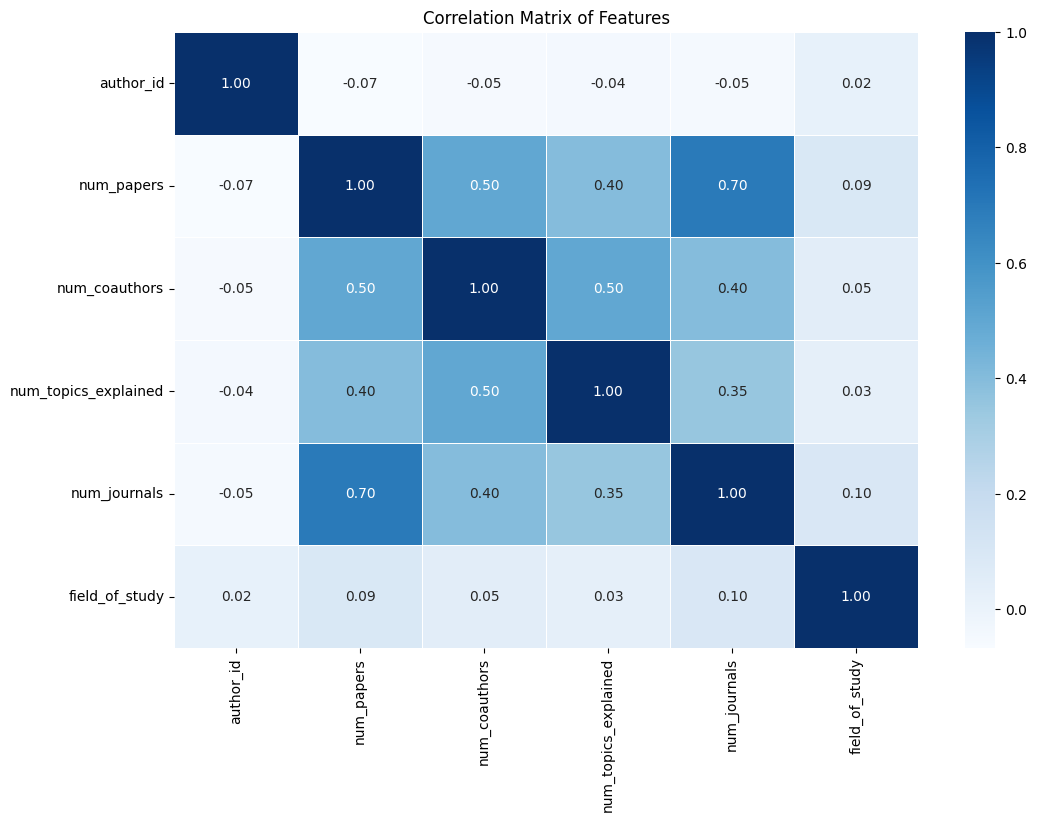

In [ ]:
corr = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()


In [ ]:
print(df.isnull().sum())
df = df.dropna(subset=['field_of_study'])


author_id               0
num_papers              0
num_coauthors           0
num_topics_explained    0
num_journals            0
field_of_study          0
dtype: int64


In [ ]:

field_counts = df.groupby(['author_id', 'field_of_study']).size().reset_index(name='count')
most_frequent_field = field_counts.loc[field_counts.groupby('author_id')['count'].idxmax()]
df = pd.merge(df, most_frequent_field[['author_id', 'field_of_study']], on='author_id', how='left')
df = df.drop(columns=['field_of_study_x']) 
df = df.drop_duplicates(subset=['author_id'])
print(df.head())


     author_id  num_papers  num_coauthors  num_topics_explained  num_journals  \
0   1400383433           8              5                     7             3   
8      4059419           2              4                     3             2   
10   144622287          20              2                     4             7   
30    12121973          65              4                    27             6   
95   104091368           8              1                     4             3   

    field_of_study_y  
0                 17  
8                 17  
10                86  
30                86  
95                86  


In [214]:
df.head()

,author_id,num_papers,num_coauthors,num_topics_explained,num_journals,field_of_study_y
0,1400383433,8,5,7,3,17
8,4059419,2,4,3,2,17
10,144622287,20,2,4,7,86
30,12121973,65,4,27,6,86
95,104091368,8,1,4,3,86


In [ ]:
X = df.drop(columns=['field_of_study_y'])  # Drop target column
y = df['field_of_study_y']  # Target is the research domain (field of study)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.35559486952675806


In [229]:
import pandas as pd
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print(comparison_df.head())



       Actual  Predicted
17005      65         81
17078      76         81
18108      53         81
7429       59         59
10695      53         93


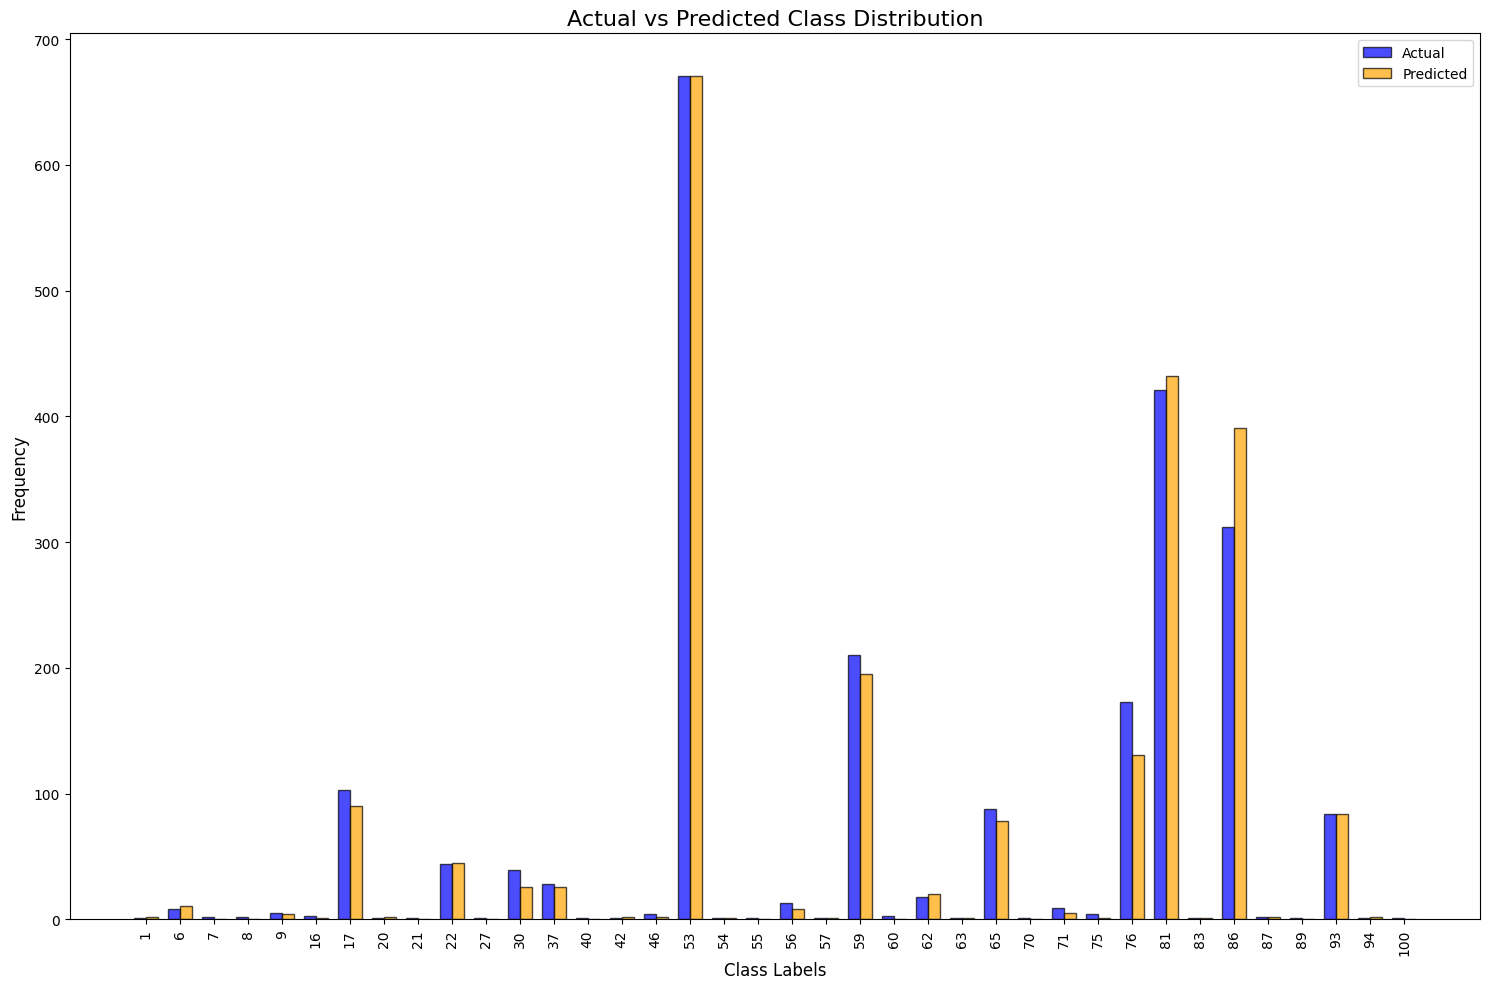

In [230]:
plt.figure(figsize=(15, 10))
unique_classes = np.unique(y_test)
actual_counts = [np.sum(y_test == cls) for cls in unique_classes]
predicted_counts = [np.sum(y_pred == cls) for cls in unique_classes]

# Bar plot for Actual vs Predicted class distributions
bar_width = 0.35
index = np.arange(len(unique_classes))

plt.bar(index, actual_counts, bar_width, label='Actual', alpha=0.7, color='blue', edgecolor='black')
plt.bar(index + bar_width, predicted_counts, bar_width, label='Predicted', alpha=0.7, color='orange', edgecolor='black')

plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Actual vs Predicted Class Distribution', fontsize=16)
plt.xticks(index + bar_width / 2, unique_classes, rotation=90, fontsize=10)
plt.legend()
plt.tight_layout() 
plt.show()


In [231]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"AUC Score (One-vs-Rest): {auc:.4f}")


AUC Score (One-vs-Rest): 0.5395


In [ ]:
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro    = recall_score(   y_test, y_pred, average='macro')
f1_macro        = f1_score(       y_test, y_pred, average='macro')

print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall    (macro): {recall_macro:.4f}")
print(f"F1‑score  (macro): {f1_macro:.4f}")


Precision (macro): 0.0675
Recall    (macro): 0.0736
F1‑score  (macro): 0.0682


c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
from neo4j import GraphDatabase
uri = "bolt://localhost:7687"  # Replace with your Neo4j URI
user = "neo4j"                # Replace with your username
password = "sajalali2003"         # Replace with your password
driver = GraphDatabase.driver(uri, auth=(user, password))

In [3]:
# Function to run a Cypher query and return the results as a pandas DataFrame
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        # Convert the result to a list of dictionaries and then to a pandas DataFrame
        return pd.DataFrame([record.data() for record in result])


In [118]:
# Query to set paperCount on relationships
query = """
MATCH (a:Author)-[r:CONTRIBUTED_TO]->(p:Paper)
WITH a, r, COUNT(p) AS paperCount
SET r.paperCount = paperCount
"""
run_query(query)


""


In [ ]:
# Query to set citationCount on relationships
query = """
MATCH (a:Author)-[r:CONTRIBUTED_TO]->(p:Paper)
SET r.citationCount = p.`Citation Count`
"""
run_query(query)


""


In [ ]:
# Query to project the graph for GDS
query = """
CALL gds.graph.project(
    'co-authorship_graph',
    ['Author', 'Paper'],
    {
        CONTRIBUTED_TO: {
            type: 'CONTRIBUTED_TO',
            properties: ['citationCount', 'paperCount']
        }
    })
YIELD graphName, nodeCount, relationshipCount
"""
run_query(query)


In [ ]:
# Query to run PageRank
query = """
CALL gds.pageRank.stream('co-authorship_graph', {
    relationshipWeightProperty: 'citationCount',                    
    relationshipWeightProperty: 'paperCount'     
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).ID AS author, score
LIMIT 1000
"""
page_rank_results = run_query(query)
page_rank_results.head()


,author,score
0,39481716,0.150000
1,1400383433,0.642097
2,4059419,0.334875
3,40392273,0.235000
4,47693041,0.150000


In [197]:
# Query to run Louvain Community Detection
query = """
CALL gds.louvain.stream('co-authorship_graph')
YIELD nodeId, communityId
RETURN gds.util.asNode(nodeId).ID AS author, communityId
LIMIT 1000
"""
louvain_results = run_query(query)
louvain_results.head()


,author,communityId
0,39481716,38853
1,1400383433,305197
2,4059419,305197
3,40392273,305197
4,47693041,38855


In [198]:
# Query to run Betweenness Centrality
query = """
CALL gds.betweenness.stream('co-authorship_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).ID AS author, score
LIMIT 1000
"""
betweenness_results = run_query(query)
betweenness_results.head()


,author,score
0,39481716,0.0
1,1400383433,47.5
2,4059419,20.0
3,40392273,11.0
4,47693041,0.0


In [123]:
# Query to run Jaccard Similarity
query = """
CALL gds.nodeSimilarity.stream('co-authorship_graph', {
    similarityMetric: 'JACCARD'
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).ID AS author1, gds.util.asNode(node2).ID AS author2, similarity
ORDER BY similarity DESC
LIMIT 1000;
"""
node_similarity_results = run_query(query)
node_similarity_results.head()


,author1,author2,similarity
0,65836547,115314850,0.964286
1,115314850,65836547,0.964286
2,145608426,122314563,0.958333
3,122314563,145608426,0.958333
4,143790585,122314563,0.956522


In [199]:
# Query to run Degree Centrality
query = """
CALL gds.degree.stream('co-authorship_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).ID AS author_id, score AS degree_centrality
LIMIT 1000
"""
degree_centrality_results = run_query(query)
degree_centrality_results.head()


,author_id,degree_centrality
0,39481716,1.0
1,1400383433,8.0
2,4059419,3.0
3,40392273,6.0
4,47693041,1.0


In [ ]:
# Standardize the column names for author identifiers
page_rank_results.rename(columns={'author': 'author_id'}, inplace=True)
degree_centrality_results.rename(columns={'author': 'author_id'}, inplace=True)
betweenness_results.rename(columns={'author': 'author_id'}, inplace=True)
louvain_results.rename(columns={'author': 'author_id'}, inplace=True)
node_similarity_results.rename(columns={'author1': 'author_id'}, inplace=True)


In [ ]:
df_combined = pd.merge(page_rank_results, degree_centrality_results, on='author_id', how='outer')
df_combined = pd.merge(df_combined, betweenness_results, on='author_id', how='outer')
df_combined = pd.merge(df_combined, louvain_results, on='author_id', how='outer')
df_combined = pd.merge(df, df_combined, on='author_id', how='inner')
df_combined.head()


,author_id,num_papers,num_coauthors,num_topics_explained,num_journals,field_of_study,score_x,degree_centrality,score_y,communityId
0,1400383433,8,5,7,3,65,0.642097,8.0,47.5,305197
1,1400383433,8,5,7,3,86,0.642097,8.0,47.5,305197
2,1400383433,8,5,7,3,17,0.642097,8.0,47.5,305197
3,1400383433,8,5,7,3,17,0.642097,8.0,47.5,305197
4,1400383433,8,5,7,3,65,0.642097,8.0,47.5,305197


In [ ]:
field_counts = df_combined.groupby(['author_id', 'field_of_study']).size().reset_index(name='count')
most_frequent_field = field_counts.loc[field_counts.groupby('author_id')['count'].idxmax()]
df_combined = pd.merge(df_combined, most_frequent_field[['author_id', 'field_of_study']], on='author_id', how='left')
df_combined = df_combined.drop(columns=['field_of_study_x'])  # Drop the previous 'field_of_study' column if it exists
df_combined = df_combined.drop_duplicates(subset=['author_id'])
print(df_combined.head())



     author_id  num_papers  num_coauthors  num_topics_explained  num_journals  \
0   1400383433           8              5                     7             3   
8      4059419           2              4                     3             2   
10   144622287          20              2                     4             7   
30    12121973          65              4                    27             6   
95   104091368           8              1                     4             3   

     score_x  degree_centrality  score_y  communityId  field_of_study_y  
0   0.642097                8.0     47.5       305197                17  
8   0.334875                3.0     20.0       305197                17  
10  0.320000               20.0     38.0        50971                86  
30  0.380388               65.0   1024.0        44924                86  
95  0.213750                8.0      7.0       156094                86  


In [ ]:
columns_to_scale = ['score_x', 'degree_centrality', 'score_y', 'communityId']
scaler = StandardScaler()
df_combined_scaled = df_combined.copy()
df_combined_scaled[columns_to_scale] = scaler.fit_transform(df_combined_scaled[columns_to_scale])
print(df_combined_scaled.head())


     author_id  num_papers  num_coauthors  num_topics_explained  num_journals  \
0   1400383433           8              5                     7             3   
8      4059419           2              4                     3             2   
10   144622287          20              2                     4             7   
30    12121973          65              4                    27             6   
95   104091368           8              1                     4             3   

     score_x  degree_centrality   score_y  communityId  field_of_study_y  
0   0.622107          -0.096675 -0.266791     1.518692                17  
8  -0.321530          -0.446706 -0.306015     1.518692                17  
10 -0.367219           0.743399 -0.280341    -0.739485                86  
30 -0.181736           3.893679  1.126019    -0.793198                86  
95 -0.693567          -0.096675 -0.324558     0.194276                86  


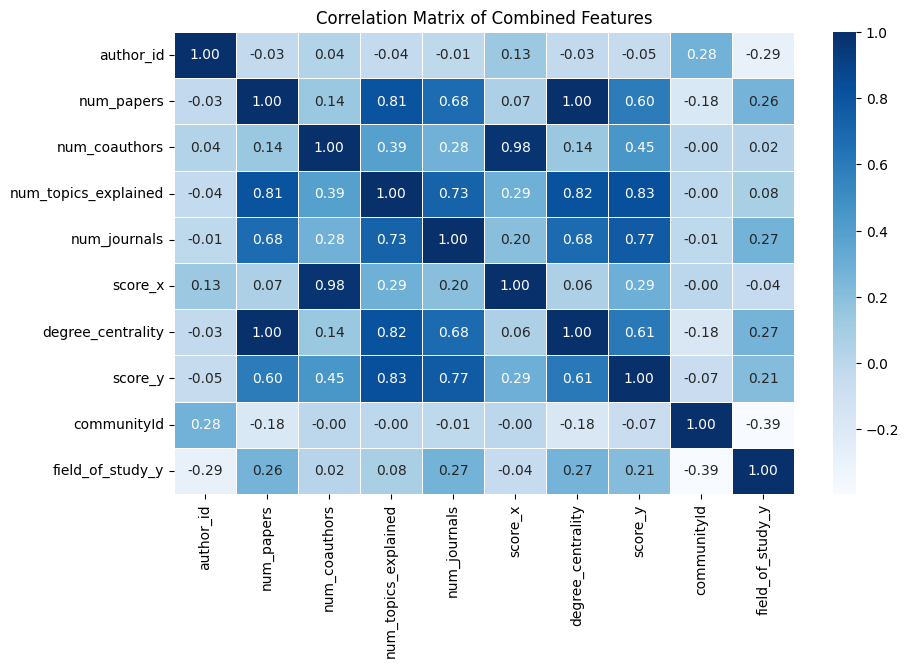

In [233]:
corr_matrix = df_combined_scaled.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Combined Features')
plt.show()


In [222]:
# Select features for the model (excluding 'field_of_study' which is the target)
features = df_combined_scaled.drop(columns=['field_of_study_y'])

# The target variable is 'field_of_study'
target = df_combined_scaled['field_of_study_y']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6


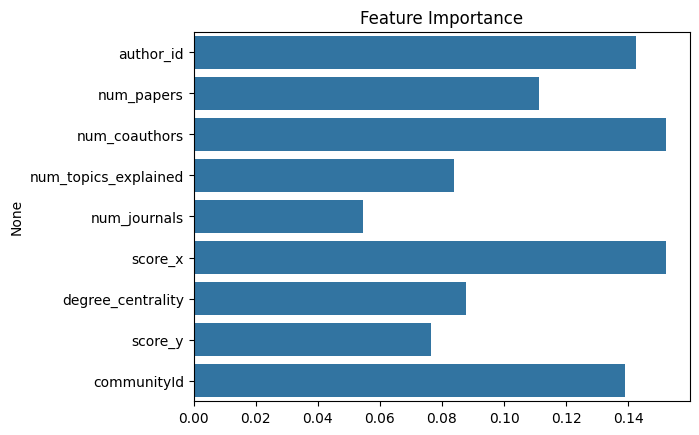

In [225]:
importance = model.feature_importances_
feat_names = features.columns
sns.barplot(x=importance, y=feat_names)
plt.title("Feature Importance")
plt.show()

In [ ]:
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro    = recall_score(   y_test, y_pred, average='macro')
f1_macro        = f1_score(       y_test, y_pred, average='macro')

print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall    (macro): {recall_macro:.4f}")
print(f"F1‑score  (macro): {f1_macro:.4f}")


Precision (macro): 0.7500
Recall    (macro): 0.6667
F1‑score  (macro): 0.5833


In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"AUC Score (One-vs-Rest): {auc:.4f}")


AUC Score (One-vs-Rest): 0.6667
